In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:


def r1(s):
    return 0.45*np.sqrt(np.cos(s)**2 + np.sin(s)**2/4)

# def r1(s):
#     return (1+0.9*np.cos(s) + 0.1*np.sin(2*s))/(2+1.5*np.cos(s))

def r2(s):
    return (np.cos(s)**10+np.sin(s)**10)**(-0.1)

def dr2(s):
    term1 = (np.cos(s)**10 + np.sin(s)**10)**(-1.1)
    term2 = np.cos(s) * np.sin(s) * (np.sin(s)**8 - np.cos(s)**8)
    return -1.0 * term1 * term2

# def r2(s):
#     return np.ones_like(s)*0.8


# def dr2(s):
#     return np.zeros_like(s)

In [3]:
from gpbr.direct.common.boundary import Point3D
def f1(X, t: float) -> float:
    return np.zeros_like(X[0])

def f2(X, t: float) -> float:
    return np.ones_like(X[0]) ## TODO: Add time dependence

In [4]:
from gpbr.direct.heat_equation.common import MFSConfig2D
T = 1 # final time
N = 7 # N+1=10 time points
# M = 16 # number of collocation and points
M = 32 # number of collocation and points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig2D(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=f1,
    f2=f2
)


In [5]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)


In [6]:
from gpbr.direct.common.boundary import StarlikeCurve
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, r2)

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

from gpbr.direct.common.boundary import StarlikeCurve

def plot_with_normals(Gamma: StarlikeCurve, normal_scale=0.2, show_points=True):
    """
    Plot a 2D starlike curve with its normal vectors.
    
    Parameters:
    -----------
    Gamma : StarlikeCurve
        The curve to plot.
    normal_scale : float, optional
        Scaling factor for normal vector length.
    show_points : bool, optional
        Whether to display points along the curve.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract coordinates
    x, y =  Gamma.points_np
    
    # Plot the curve
    ax.plot(x, y, 'b-', linewidth=2, label='Curve')
    
    # Plot points if requested
    if show_points:
        ax.plot(x, y, 'bo', markersize=4, alpha=0.5)

    nx, ny = Gamma.normals_np
    ax.quiver(x, y, nx/10, ny/10, color='red', scale=normal_scale,
                angles='xy', scale_units='xy', width=0.001,
                headwidth=10, headlength=10)
    
    # Set axis limits with padding
    all_x, all_y = Gamma.points_np
    max_extent = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    padding = max_extent * 0.5
    
    ax.set_xlim([min(all_x) - padding, max(all_x) + padding])
    ax.set_ylim([min(all_y) - padding, max(all_y) + padding])
    
    # Set equal aspect ratio to properly visualize angles
    ax.set_aspect('equal')
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title('Curve with Normal Vectors', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_g1(G1, title="Starlike Curve", show_normals=False, color='#1f77b4', 
            figsize=(10, 8), dpi=120, save_path=None):
    """
    Plot a starlike curve with enhanced visual presentation.
    
    Parameters:
    -----------
    G1 : StarlikeCurve
        The starlike curve to plot.
    title : str, optional
        Title for the plot.
    show_normals : bool, optional
        Whether to display normal vectors.
    color : str, optional
        Color for the curve.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    dpi : int, optional
        Resolution of the figure.
    save_path : str, optional
        If provided, save the figure to this path.
    """
    # Set up the figure with clean style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Get points and plot with enhanced styling
    g1_x, g1_y = G1.points_np
    
    # Plot filled curve with fade
    ax.fill(g1_x, g1_y, color=color, alpha=0.2)
    
    # Plot curve with solid color instead of gradient
    ax.plot(g1_x, g1_y, color=color, linewidth=2.5, alpha=0.8)
    
    # Add a few markers along the curve
    num_markers = 12
    marker_indices = np.linspace(0, len(g1_x)-1, num_markers, dtype=int)
    ax.plot(g1_x[marker_indices], g1_y[marker_indices], 'o', color='navy', 
            markersize=5, alpha=0.8)

    # Enhance the appearance
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    
    
    # Calculate max radius for setting limits
    max_radius = max(np.sqrt(g1_x**2 + g1_y**2))
    
    # Adjust limits with padding
    padding = max_radius * 0.1
    ax.set_xlim([-max_radius-padding, max_radius+padding])
    ax.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Tight layout
    plt.tight_layout()
    
    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

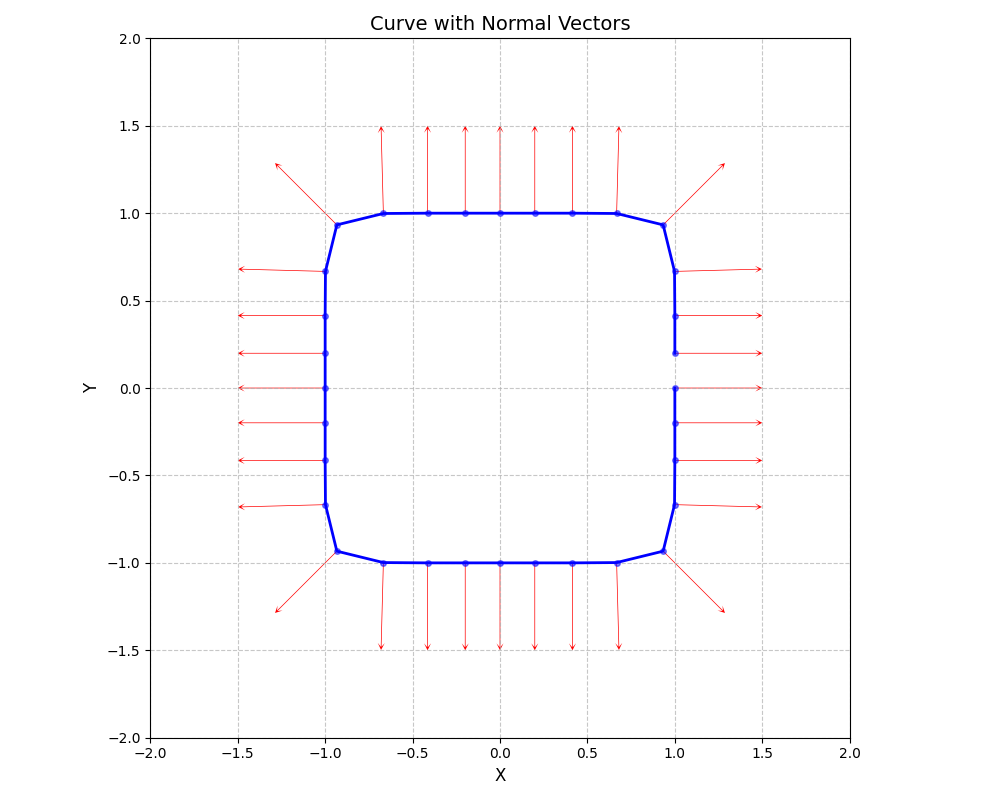

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Curve with Normal Vectors'}, xlabel='X', ylabel='Y'>)

In [8]:
plot_with_normals(Gamma2)

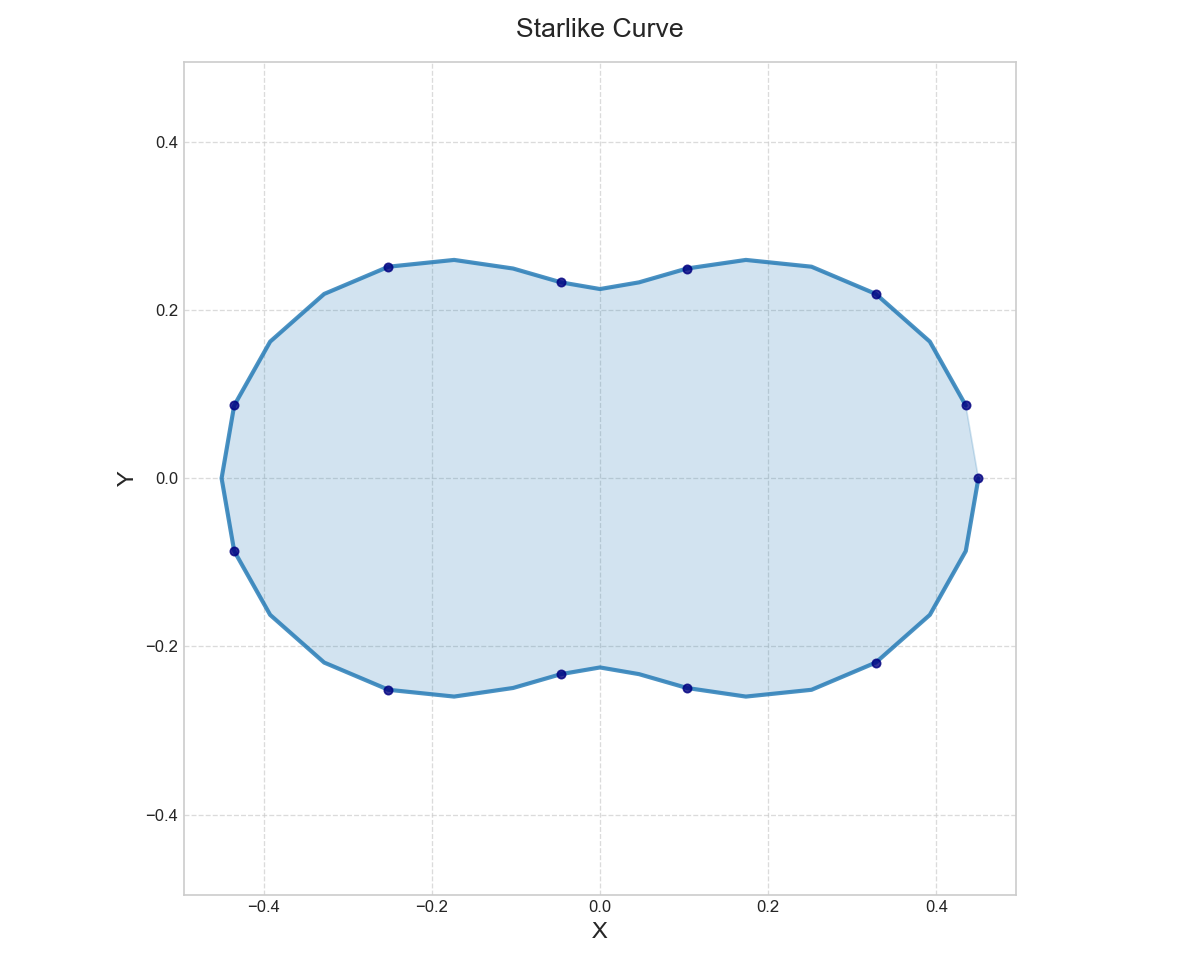

(<Figure size 1200x960 with 1 Axes>,
 <Axes: title={'center': 'Starlike Curve'}, xlabel='X', ylabel='Y'>)

In [9]:
G1_plot = StarlikeCurve.from_radial(mfs_data.collocation, r1)
plot_g1(G1_plot)

In [10]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs, matfundamental_sequence_2d
from gpbr.direct.heat_equation.helpers import form_fs_matrix, matdbu_2d, matform_fs_vector_2d

from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, r1_func)
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)

    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        try:
            alpha_n = lstsq(PHI_MAT, F)[0]
        except np.linalg.LinAlgError:
            print("Failed to solve the linear system")
            return None
        fs_coefs.alpha[n] = alpha_n.T

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    du_vals[:] = np.nan

    for ni in range(0, N+1):
        du_vals[ni] = matdbu_2d(Gamma2.points_np, Gamma2.normals_np, ni, source_points, fs_coefs, mfs_data).ravel()
    return du_vals


In [11]:
from gpbr.tools.noise import noise
exact_heat_flux = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)
# heat_flux = noise(exact_heat_flux, 0.0, seed=495882730)
heat_flux = exact_heat_flux

C:\Users\Programmer\AppData\Local\Temp\ipykernel_8268\2911746534.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_n = lstsq(PHI_MAT, F)[0]


In [12]:
heat_flux

array([[ 3.98716431e+00,  3.78244467e+00,  3.41064370e+00,
         1.89727726e+00,  3.40860217e+00,  3.76395490e+00,
         3.95065754e+00,  4.04514371e+00,  3.95065754e+00,
         3.76395490e+00,  3.40860217e+00,  1.89727726e+00,
         3.41064370e+00,  3.78244467e+00,  3.98716431e+00,
         4.08961608e+00,  3.98716431e+00,  3.78244467e+00,
         3.41064370e+00,  1.89727726e+00,  3.40860217e+00,
         3.76395490e+00,  3.95065754e+00,  4.04514371e+00,
         3.95065754e+00,  3.76395490e+00,  3.40860217e+00,
         1.89727726e+00,  3.41064370e+00,  3.78244467e+00,
         3.98716431e+00,  4.08961608e+00],
       [ 4.90039527e-02, -1.23806932e-01, -9.26089830e-01,
        -7.38637020e-01, -9.36004018e-01, -2.04531244e-01,
        -1.05345862e-01, -1.84476426e-01, -1.05345862e-01,
        -2.04531244e-01, -9.36004018e-01, -7.38637020e-01,
        -9.26089830e-01, -1.23806932e-01,  4.90039527e-02,
         1.45786296e-03,  4.90039527e-02, -1.23806932e-01,
        -9.26

## Fitness calculation

In [13]:
from scipy import integrate
def calc_l2_norm(ncoll, thetas, tn, exact, approx):
    diff_squared = (approx - exact) ** 2
    # First integrate over theta for each time
    theta_integrals = integrate.trapezoid(diff_squared, thetas, axis=1)
    # Then integrate the result over time
    total_integral = integrate.trapezoid(theta_integrals, tn)
    return total_integral

In [14]:
def feasable(ext_boundary_vals, rfunc, rvals):
    # Not closed curve
    if abs(rfunc(0) - rfunc(2*np.pi)) > 1e-10:
        return False

    if not np.isfinite(rvals).all():
        return False

    # Singularities
    if np.any(np.less_equal(rvals, 1e-5)):
        return False

    # Exceeds the outer boundary
    if np.any(np.greater_equal(rvals, ext_boundary_vals)):
        return False
    
    return True

In [15]:
def evaluate(mfsd, tlb, ind):
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta)
    if not tlb.feasable(ind_compile, ind_values):
        return (1e6, )

    g2_approx = tlb.calc_normals(ind_compile)
    if g2_approx is None:
        print("Failed to calculate g2_approx for individual :", ind)
        return (1e6, )
    if isinstance(ind_values, float) or isinstance(ind_values, int):
        ind_values = np.ones_like(mfsd.collocation.theta) * ind_values

    if ind_values.shape == ():
        ind_values = np.ones_like(mfsd.collocation.theta) * ind_values
    return (tlb.norm(g2_approx) + integrate.trapezoid(ind_values**2, mfsd.collocation.theta, axis=0)*1e-4, )

### Primitive set

In [16]:
from deap import gp
from gpbr.gp.funcs import pow2, sqrtabs, expplusone
from functools import partial

pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(np.add, 2)
# pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(sqrtabs, 1)
# pset.addPrimitive(pow2, 1)
pset.addPrimitive(expplusone, 1)
# pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])
# pset.addEphemeralConstant('randval', lambda: np.random.rand())
pset.addEphemeralConstant('randfloat', partial(np.random.uniform, -1.0, 1.0))
# pset.addTerminal(np.pi, 'pi')

pset.renameArguments(ARG0="s")

In [17]:
pset.primitives

defaultdict(list,
            {object: [<deap.gp.Primitive at 0x18826b2a7a0>,
              <deap.gp.Primitive at 0x18826b2aa70>]})

### Individual representation

In [18]:
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, subtrees_values=None)

### Toolbox compiling

In [19]:
toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=5, max_=12)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [20]:
toolbox.register('feasable', feasable, Gamma2.rf(mfs_data.collocation.theta))
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, f1, f2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.M, mfs_data.collocation.theta, mfs_data.tn, heat_flux)
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

In [21]:
from gpbr.gp.simplyfications import simplify_constant_subtrees
# toolbox.register('simplify_constants', simplify_constant_subtrees, toolbox=toolbox, eval_values=mfs_data.collocation.theta) # Need to fix later, bad idea to send toolbox itself
toolbox.register('simplify_constants', simplify_constant_subtrees) # Need to fix later, bad idea to send toolbox itself

In [22]:
from gpbr.gp.evaluators import evaluate_subtrees
toolbox.register('precalculate', evaluate_subtrees, pset=pset, arg_shape=mfs_data.collocation.theta.shape, s=mfs_data.collocation.theta) ## TODO: add args naming from pset

### Selection

In [23]:
toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selBest)
# toolbox.register("select", tools.selTournament, tournsize=4)
# toolbox.register("select", tools.selDoubleTournament, fitness_size=3, fitness_first=False, parsimony_size=1.4)
# toolbox.register("select", tools.selNSGA2)
# toolbox.register("select", tools.selLexicase)
# toolbox.register("select", tools.selAutomaticEpsilonLexicase)

### Operators

In [24]:
import random
def random_operator(*args, options):
    return random.choice(options)(*args)

In [25]:
from gpbr.gp.operators import cxLinearCombination


toolbox.register("mate_onepoint", gp.cxOnePoint)
toolbox.register("mate_lincomb", cxLinearCombination, pset=pset)
toolbox.register("mate_leaf_based", gp.cxOnePointLeafBiased, termpb=0.35)
mate_operators = [toolbox.mate_lincomb, toolbox.mate_onepoint, toolbox.mate_leaf_based]

toolbox.register("expr_mut", gp.genHalfAndHalf, min_=1, max_=3)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_ephemeral", gp.mutEphemeral, mode="one")
toolbox.register("mutate_insert", gp.mutInsert, pset=pset)
toolbox.register("mutate_shrink", gp.mutShrink)
# toolbox.register("mutate_shift", mutate_angular_shift, pset=pset)
# toolbox.register("mutate_shrink", gp.mutShrink)
mutate_operators = [toolbox.mutate_uniform, toolbox.mutate_node_replacement, toolbox.mutate_ephemeral, toolbox.mutate_insert]


toolbox.register("mate", random_operator, options=mate_operators)
toolbox.register("mutate", random_operator, options=mutate_operators)

### Bloat control

In [27]:
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
import operator
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [28]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [29]:
from gpbr.gp.algorithms import customEaMuPlusLambda

MU, LAMBDA = 100, 200
pop, logbook = customEaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                            cxpb=0.7, mutpb=0.3, ngen=20, 
                                            stats=mstats, halloffame=hof)

d:\phd\gpbr\gpbr\gp\funcs.py:47: RuntimeWarning: overflow encountered in exp
  return np.exp(np.ones_like(x, dtype=np.float64) + x)
d:\phd\gpbr\gpbr\gp\evaluators.py:36: RuntimeWarning: invalid value encountered in cos
  val = np.asanyarray(func(*child_vals), dtype=np.float64)
d:\phd\gpbr\gpbr\gp\evaluators.py:36: RuntimeWarning: invalid value encountered in sin
  val = np.asanyarray(func(*child_vals), dtype=np.float64)
c:\Users\Programmer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Programmer\AppData\Local\Temp\ipykernel_8268\2911746534.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_n = lstsq(PHI_MAT, F)[0]
C:\

   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max  	min      	nevals	std   	avg	gen	max	min	nevals	std    
0  	500   	930015	0  	1e+06	0.0800715	500   	255092	31 	0  	250	1  	500   	31.2526
1  	200   	850056	1  	1e+06	0.16166  	200   	356937	33.32	1  	133	1  	200   	32.796 
2  	200   	700117	2  	1e+06	0.0520696	200   	458079	28.01	2  	129	1  	200   	28.9684
3  	200   	370150	3  	1e+06	0.0332629	200   	482689	14.84	3  	109	1  	200   	20.0598
4  	200   	60067.3	4  	1e+06	0.0290578	200   	237470	6.46 	4  	33 	1  	200   	7.36264
5  	200   	2.72277	5  	41.579	0.0290578	200   	6.518 	5.45 	5  	33 	1  	200   	7.62938
6  	200   	0.537487	6  	10.4439	0.0290578	200   	1.68981	5.03 	6  	24 	1  	200   	7.03058
7  	200   	0.0422307	7  	0.172063	0.0290578	200   	0.0194439	4.83 	7  	30 	1  	200   	7.

In [ ]:
print(pset.primitives[object])

[<deap.gp.Primitive object at 0x000002AD8324ABB0>, <deap.gp.Primitive object at 0x000002AD8324AC50>, <deap.gp.Primitive object at 0x000002AD8324ACA0>, <deap.gp.Primitive object at 0x000002AD8324AD40>, <deap.gp.Primitive object at 0x000002AD8324AE30>, <deap.gp.Primitive object at 0x000002AD8324AE80>]


In [ ]:
# # MU, LAMBDA = 100, 200
# # pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
# #                                             cxpb=0.7, mutpb=0.3, ngen=100, 
# #                                             stats=mstats, halloffame=hof)

# MU, LAMBDA = 100, 200
# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=20, 
#                                             stats=mstats, halloffame=hof)
# for ind in pop:
#     ind = toolbox.simplify_constants(ind, mfs_data.collocation.theta)

# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=20, 
#                                             stats=mstats, halloffame=hof)

In [30]:
print("Best individual is: ", hof[0])

Best individual is:  multiply(0.9520135480891155, cos(add(sqrtabs(cos(sin(cos(s)))), 0.27465481811530923)))


In [31]:
best_simplified = toolbox.simplify_constants(hof[0])

In [32]:
str(best_simplified[0])

'multiply(0.9520135480891155, cos(add(sqrtabs(cos(sin(cos(s)))), 0.27465481811530923)))'

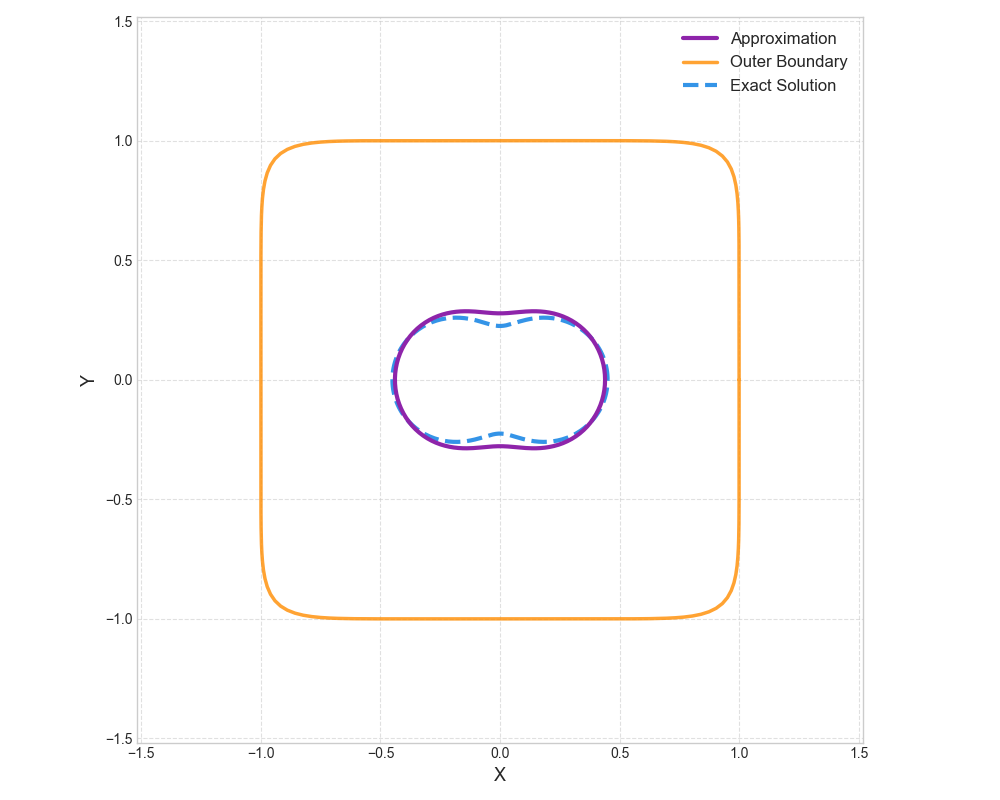

In [33]:
from gpbr.tools.plot import plot_radial_boundaries_2d

fig_reconsructed = plot_radial_boundaries_2d(r1, toolbox.compile(expr=hof[0]), r2)
fig_reconsructed.savefig('./results/2d_2_reconstructed.png', dpi=300, transparent=True)

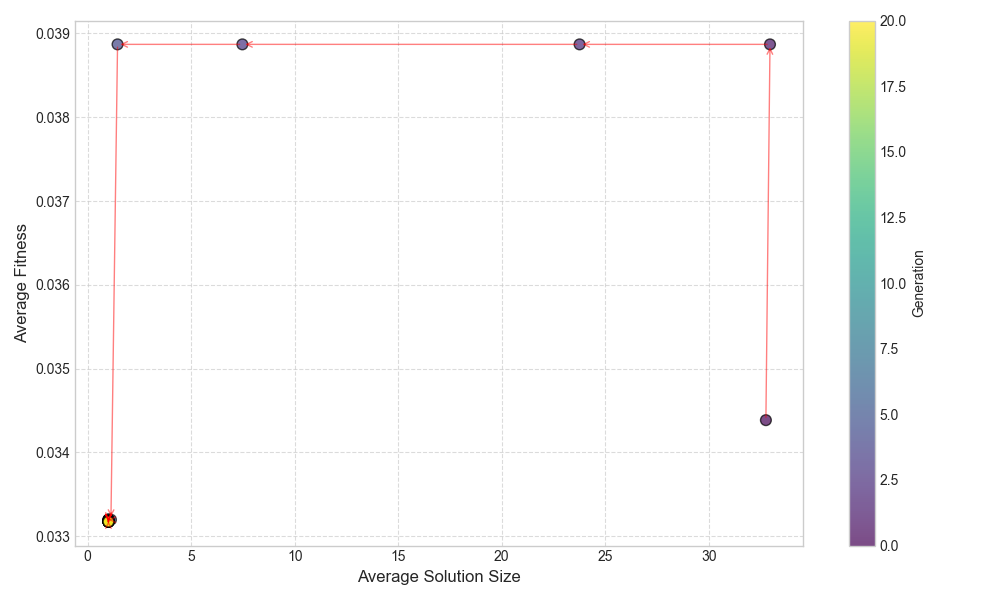

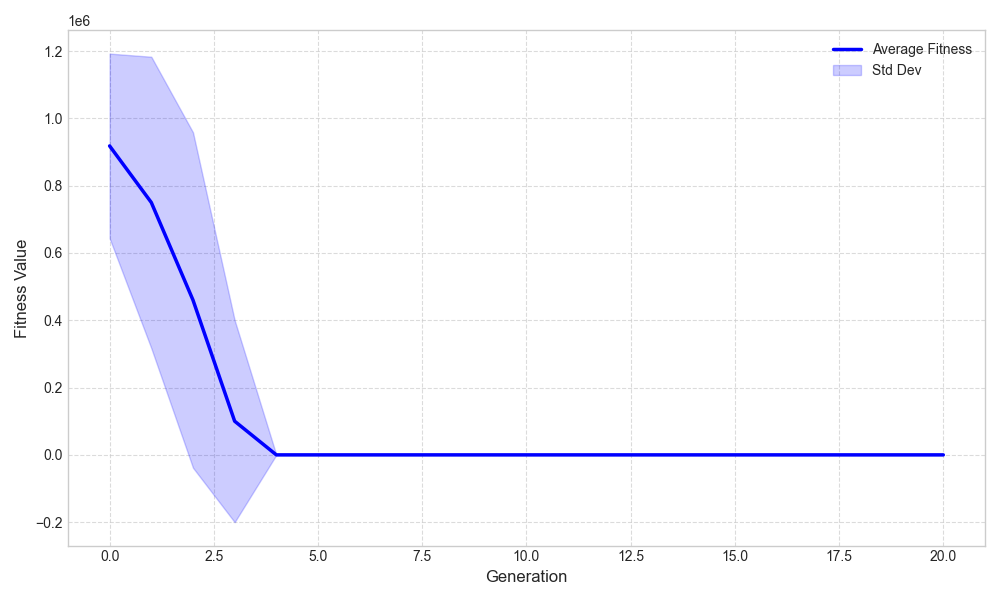

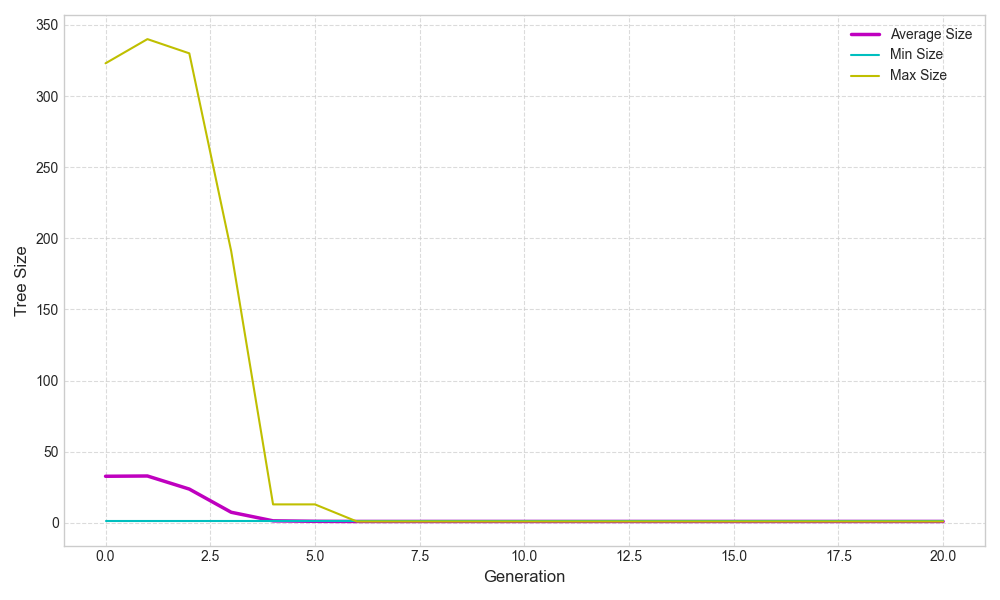

In [ ]:
from gpbr.tools.plot import plot_evolution_stats

# Example usage
fig_fitness, fig_size, fig_correlation = plot_evolution_stats(
    logbook,
    title="GP Boundary Approximation"
)

# You can save each figure separately
fig_fitness.savefig('./results/2d_2_fitness_evolution.png', dpi=300)
fig_size.savefig('./results/2d_2_size_evolution.png', dpi=300)
fig_correlation.savefig('./results/2d_2_size_fitness_correlation.png', dpi=300)

# Or display them
plt.show()

In [ ]:
def plot_both_raw(exact_rfunc, approx_rfunc, n_theta=256, title="Exact vs. Approximate radial functions"):
    import matplotlib.pyplot as plt
    import numpy as np

    fig1, ax1 = plt.subplots(figsize=(10, 8))
    thetas = np.linspace(0, 2 * np.pi, n_theta)

    # Calculate radius values
    exact_rvals = exact_rfunc(thetas)
    approx_rvals = approx_rfunc(thetas)

    # If approx_rvals is a scalar, broadcast to array
    if np.isscalar(approx_rvals) or (isinstance(approx_rvals, np.ndarray) and approx_rvals.shape == ()):
        approx_rvals = np.ones_like(thetas) * approx_rvals

    # Exact solution - use a distinct blue
    ax1.plot(thetas, exact_rvals, color='#1E88E5', linestyle='--', linewidth=3,
             label='Exact Solution', alpha=0.9)

    # Approximation - use a vibrant purple
    ax1.plot(thetas, approx_rvals, color='#8E24AA', linewidth=3, label='Approximation')

    ax1.set_title(title)
    ax1.set_xlabel("Theta")
    ax1.set_ylabel("Radius")
    ax1.legend()
    return fig1

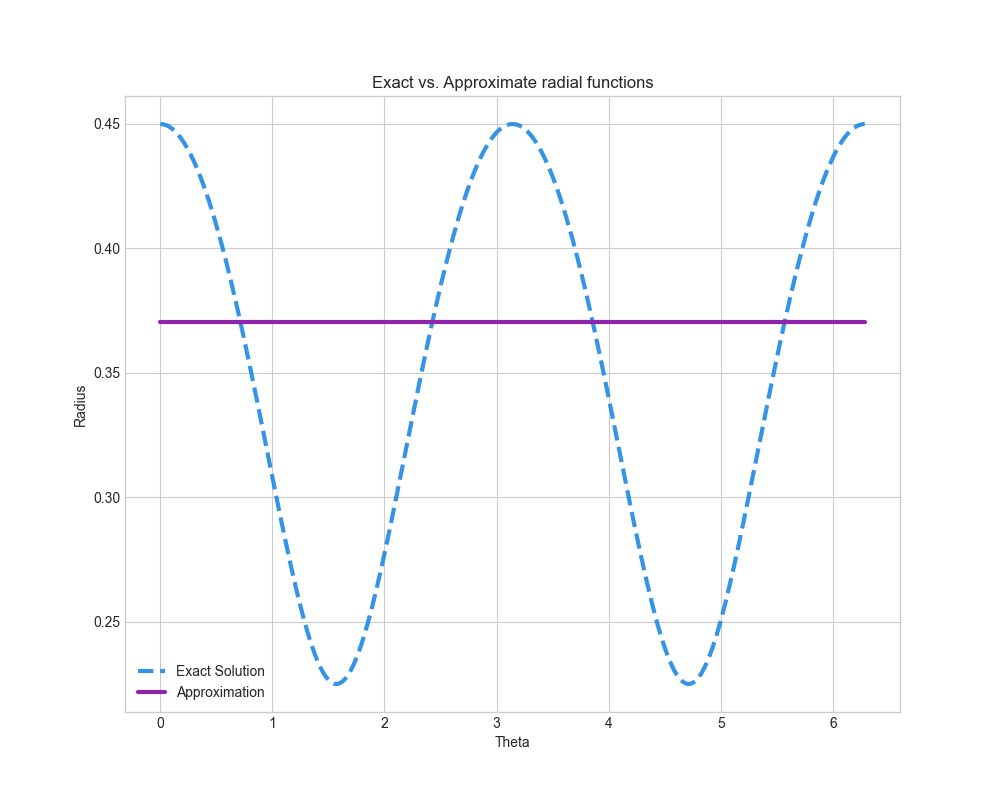

In [ ]:
fig_raw = plot_both_raw(r1, toolbox.compile(expr=hof[0]))

In [ ]:
s = np.linspace(0, 2*np.pi, 256)
exact_rvals = r1(s)
approx_rvals = toolbox.compile(expr=hof[0])(s)

# np.sqrt(integrate.trapezoid((exact_rvals-approx_rvals)**2, s)/integrate.trapezoid(exact_rvals, s))
np.sqrt(integrate.trapezoid((exact_rvals-approx_rvals)**2, s, axis=0)/integrate.trapezoid(exact_rvals**2, s,axis=0))

0.23092798611311025

In [ ]:
approx_func = toolbox.compile(expr=hof[0])
np.sqrt(integrate.quad(lambda s: (r1(s) - approx_func(s))**2, 0, 2*np.pi)[0]/integrate.quad(lambda s: (approx_func(s))**2, 0, 2*np.pi)[0])

0.22173126997684112